# Network analysis for coauthors 

Following tutorial from [this](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#advanced-networkx-community-detection-with-modularity).

In [42]:
%load_ext autoreload
%autoreload 2

import csv
import networkx as nx
from operator import itemgetter
from functools import reduce
from collections import Counter
import operator
import community 
import matplotlib.pyplot as plt
import statistics as s
import pandas as pd
import seaborn as sns

from src.util import load_coauthor_nx, ddir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Read data/ setup network

In [30]:
fn_spp = ddir + '2019-05-23-Apoidea world consensus file Sorted by name 2019 describers_2.0-denormalised.csv'
spp = pd.read_csv(fn_spp)[["idx", "full.name.of.describer.n"]]
spp = spp[spp.duplicated(subset="idx", keep=False)] # keep only those with >1 authors

In [31]:
(G, nodes) = load_coauthor_nx() # abstracted into src

N nodes 361 ; N not nodes: 368
Proportion who did not coauthor 50.48010973936899
Name: 
Type: Graph
Number of nodes: 361
Number of edges: 463
Average degree:   2.5651


## Network metrics

### Basic functions

In [32]:
# If your Graph has more than one component, this will return False:
print("More than one component: ", not(nx.is_connected(G)))

More than one component:  True


In [33]:
# How to access individual nodes
G.nodes()['Charles Duncan Michener']["country_of_residence"]

'US'

In [34]:
G.nodes()['Charles Duncan Michener']["ns_spp_n"]

444

In [35]:
# How to access edges
G.edges(('Abdulaziz S. Alqarni'), data=True)

EdgeDataView([('Abdulaziz S. Alqarni', 'Mohammed A. Hannan', {'weight': 2.0}), ('Abdulaziz S. Alqarni', 'Michael Scott Engel', {'weight': 2.0}), ('Abdulaziz S. Alqarni', 'Victor Hugo Gonzalez [Betancourt]', {'weight': 1.0})])

### Network metrics

In [36]:
density = nx.density(G)
print("Network density:", round(density*100, 1), "%")

Network density: 0.7 %


**Network density** is the ratio of one node to all possible edges. Gives idea of how closely knit the network is. Ranges from 0 to 1.

In [37]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", round(triadic_closure*100, 1), "%")

Triadic closure: 14.2 %


**Transitivity** is one metric of measuring tradic closure ("triangles" formed as if two people know each other, they are more likely to know another). It is the ratio of all triangles over all possible triangles. Range from 0 to 1. 

In [39]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

degree_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
degree_df = degree_df.reset_index()

print(degree_df[['index', 'degree']].sort_values("degree", ascending=False)[0:10])
print("\nMedian centrality:", s.median(degree_df.degree))

                                 index  degree
235                Michael Scott Engel      30
54             Charles Duncan Michener      23
323                  Terry L. Griswold      19
4                          Alain Pauly      19
150               Jesus Santiago Moure      19
300                Shôichi F. Sakagami      17
249                     Osamu Tadauchi      17
106  Gabriel Augusto Rodrigues de Melo      15
334  Victor Hugo Gonzalez [Betancourt]      15
324      Theodore Dru Alison Cockerell      15

Median centrality: 1


**Centrality** are a group of metrics to determine which nodes are most important.

**Degree** is the sum of edges. Those with the highest degree are known as **"hubs"**.

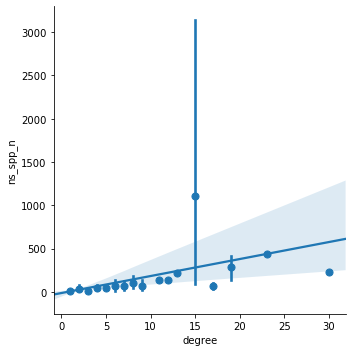

In [70]:
sns.lmplot(x='degree', y='ns_spp_n', data=degree_df, x_estimator=np.mean)
# https://seaborn.pydata.org/tutorial/regression.html

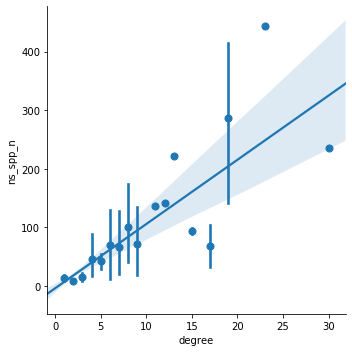

In [71]:
condition = degree_df['ns_spp_n'] <500
sns.lmplot(x='degree', y='ns_spp_n', data=degree_df[condition], x_estimator=np.mean)
# https://seaborn.pydata.org/tutorial/regression.html

In [10]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient="index", columns=['value'])
eigenvector_df = eigenvector_df.reset_index()

print(eigenvector_df.sort_values('value', ascending=False)[0:10])
print("\nMedian eigenvector centrality:", s.median(eigenvector_df['value']))

                                 index     value
235                Michael Scott Engel  0.460701
54             Charles Duncan Michener  0.341882
323                  Terry L. Griswold  0.321461
334  Victor Hugo Gonzalez [Betancourt]  0.294204
268              Ricardo Ayala Barajas  0.196201
138     Ismael Alejandro Hinojosa-Díaz  0.184564
274                   Robert W. Brooks  0.182049
158               John Stoskopf Ascher  0.169752
240              Molly Greer Rightmyer  0.141194
106  Gabriel Augusto Rodrigues de Melo  0.135495

Median eigenvector centrality: 0.003972729626010645


**Eigenvector centrality** is an extension, including values from the neighbour's centrality too.

In [12]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient="index", columns=["value"])
betweenness_df = betweenness_df.reset_index()

print(betweenness_df.sort_values('value', ascending=False)[0:10])
print("\nMedian betweenness centrality:", s.median(betweenness_df['value']))

                                 index     value
54             Charles Duncan Michener  0.172105
235                Michael Scott Engel  0.151704
150               Jesus Santiago Moure  0.132085
4                          Alain Pauly  0.102802
323                  Terry L. Griswold  0.094475
300                Shôichi F. Sakagami  0.089539
226                 Maximilian Schwarz  0.073034
249                     Osamu Tadauchi  0.072153
259           Philip Hunter Timberlake  0.060167
334  Victor Hugo Gonzalez [Betancourt]  0.058586

Median betweenness centrality: 0.0


**Betweenness centrality** tabulates minimum of all shortest paths (see below) to pass through that node. Range from 0 to 1.
 

In [13]:
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

cen_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

check = (cen_df['degree'] <= 5) & (cen_df['betweenness'] >= s.median(cen_df['betweenness'])) # use 4 instead of median of 1
brokers = cen_df[['degree', 'betweenness', 'country_of_residence']][check].sort_values('betweenness', ascending=False)[1:20]
print(brokers)
brokers.to_csv(ddir+'eda2_auth/2019-11-07-coauth-brokers.csv')

                                      degree  betweenness country_of_residence
Mariano Lucia                              3     0.023799                   AR
Silvana P. Durante                         3     0.023491                   AR
Maxim Yurievich Proshchalykin              5     0.018292                   RS
Jerome George Rozen, Jr.                   5     0.018167                   US
João Maria Franco de Camargo               5     0.012802                   BR
Yuriy Andreyevich Pesenko                  5     0.012383                   RS
Roy R. Snelling                            4     0.012094                   US
Keizô Yasumatsu                            3     0.011916                   JA
Zach M. Portman                            2     0.011885                   US
Holger Heinrich Dathe                      4     0.011387                   GM
David Ward Roubik                          4     0.011170                   PM
Jason Gibbs                                4     0.0

In [14]:
print(cen_df[cen_df.index=='Philip Hunter Timberlake'][['degree', 'eigenvector', 'country_of_residence']])
# Timberlake was a “bridge” to Michener and Cockerell. 

                          degree  eigenvector country_of_residence
Philip Hunter Timberlake       2     0.043472                   US


In [15]:
print(cen_df.sort_values("eigenvector", ascending=False)[["eigenvector", "degree"]][0:10])

                                   eigenvector  degree
Michael Scott Engel                   0.460701      30
Charles Duncan Michener               0.341882      23
Terry L. Griswold                     0.321461      19
Victor Hugo Gonzalez [Betancourt]     0.294204      15
Ricardo Ayala Barajas                 0.196201       7
Ismael Alejandro Hinojosa-Díaz        0.184564       7
Robert W. Brooks                      0.182049       8
John Stoskopf Ascher                  0.169752       6
Molly Greer Rightmyer                 0.141194       5
Gabriel Augusto Rodrigues de Melo     0.135495      15


In [16]:
print("Mean\n", round(cen_df.median(), 5))
print("Count\n", cen_df.count())

Mean
 degree         1.00000
betweenness    0.00000
eigenvector    0.00397
dtype: float64
Count
 country_of_residence    361
degree                  361
betweenness             361
eigenvector             361
dtype: int64


A **broker** is one where clusters of subgraphs need to pass through you, they usually "have high betweenness centrality but low degree".


In [17]:
def shortest_path(n1, n2):
    shortest_path = nx.shortest_path(G, source=n1, target=n2)
    print("Shortest path between ", n1, " and ", n2, ":", shortest_path)
    print("Length of that path:", len(shortest_path)-1, "\n")
    
shortest_path("Theodore Dru Alison Cockerell", "Jesus Santiago Moure")
shortest_path("Chao-dong Zhu", "Michael Scott Engel")

Shortest path between  Theodore Dru Alison Cockerell  and  Jesus Santiago Moure : ['Theodore Dru Alison Cockerell', 'Philip Hunter Timberlake', 'Charles Duncan Michener', 'Jesus Santiago Moure']
Length of that path: 3 

Shortest path between  Chao-dong Zhu  and  Michael Scott Engel : ['Chao-dong Zhu', 'Michael Kuhlmann', 'Maxim Yurievich Proshchalykin', 'Holger Heinrich Dathe', 'Michael Scott Engel']
Length of that path: 4 



**Shortest path** allows one to see how many "steps" it takes to reach from one node to another.

Possible analysis: how one important node from one "module" links to another important node in another "module", i.e. who are the bridges.

Network diameter of largest component: 11


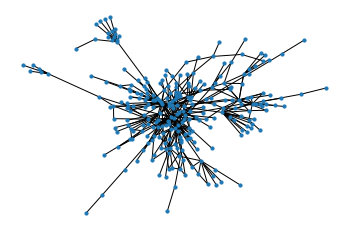

In [18]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len) # max number of nodes

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

# Plot subgraph
plt.plot()
nx.draw(subgraph, with_labels=False, node_size=10)

# How to improve graphing: https://networkx.github.io/documentation/latest/auto_examples/index.html

**Network diameter** is the length of the longest of shortest path in the network. Gives idea of size of network from one end to another. The largest subgraph gives an idea of the diameter of the entire network.

Compared to Newman (2006), the diameter range from 20-30. Here, it's 11, suggesting it is more connected.

In [19]:
# Get subgraphs
subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("Number of subgraphs:", len(subgraphs))
dia_li = []
nod_li = []
for i in subgraphs:
    dia_li.append(nx.diameter(G.subgraph(i)))
    nod_li.append(len(i))

print("Median diameter:", s.median(dia_li))
print("Diameter:", dia_li, "\n")

print("Median number of nodes:", s.median(nod_li))
print("Number of nodes when = 2 nodes:", sum([x==2 for x in nod_li]))
print("Number of nodes:", nod_li)

Number of subgraphs: 42
Median diameter: 1.0
Diameter: [11, 2, 2, 3, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

Median number of nodes: 2.0
Number of nodes when = 2 nodes: 33
Number of nodes: [260, 6, 5, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [20]:
subgraph_info = {}
total_spp = 0
for i in range(1, nod_li.index(2)):
    subgraph = subgraphs[i]
    countries = Counter([G.nodes()[p]["country_of_residence"] for p in subgraph])
    N_species_li = [list(spp[spp["full.name.of.describer.n"] == p].idx) for p in subgraph]
    N_species = set(list(reduce(lambda x,y: x+y, N_species_li)))
    N_synonyms = len([x for x in N_species if x > 20669])
    N_species = len(N_species)
    print(len(subgraph), N_species, N_synonyms, subgraph,  dict(countries))
    subgraph_info[i] = {'N_species': N_species,
                        'N_synonyms': N_synonyms,
                        'N_nodes': len(subgraph),
                        'id_nodes': subgraph,
                        'countries': dict(countries)}
    total_spp = total_spp + N_species
pd.DataFrame.from_dict(subgraph_info, orient='index').to_csv(ddir+'eda2_auth/2019-11-07-coauth-subgraphs.csv')
print("Total species contribution:", total_spp)

6 35 4 {'V. K. Tewari', 'Rajiv K. Gupta', 'Sabita Simlote', 'P. Girish Kumar', 'Sundar Lal Sharma', 'Gaurav Sharma'} {'IN': 6}
5 3 0 {'Juan Carlos Sandino-Franco', 'Alejandro Parra-H', 'Rodulfo Ospina-Torres', 'Santiago Ramírez', 'Robert Louis Dressler'} {'CO': 3, 'US': 1, 'CS': 1}
5 33 0 {'Terry F. Houston', 'Michael Batley', 'Remko Leijs', 'Katja Hogendoorn', 'Glynn V. Maynard'} {'AS': 5}
5 2 0 {'Paul Hugh Williams', 'Sydney Cameron', 'Ya Tang', 'Jian Yao', 'Sydney G. Cannings'} {'UK': 1, 'US': 2, 'CH': 1, 'CA': 1}
4 3 0 {'Cindy Julieth Celis', 'José Ricardo Cure', 'Marlene Lucia Aguilar-Benavides', 'Dieter Wittmann'} {'CO': 3, 'GM': 1}
4 2 2 {'Sarah E. Radloff', 'H. Randall Hepburn', 'Deborah R. Smith', 'Gard W. Otis'} {'SF': 2, 'US': 1, 'CA': 1}
3 1 1 {'Gerhard K. H. Przemeck', 'Martin Hrabé de Angelis', 'Andreas Bertsch'} {'GM': 3}
3 19 13 {'Franz von Wagner', 'Heinrich Friedrich August Karl Ludwig Friese', 'Karl Wilhelm von Dalla Torre'} {'GM': 2, 'AU': 1}
Total species contribut

                 0                  1                 2
0     V. K. Tewari     Rajiv K. Gupta   {'weight': 3.0}
1   Rajiv K. Gupta  Sundar Lal Sharma  {'weight': 24.0}
2   Rajiv K. Gupta     Sabita Simlote  {'weight': 19.0}
3   Rajiv K. Gupta      Gaurav Sharma   {'weight': 1.0}
4   Rajiv K. Gupta    P. Girish Kumar   {'weight': 1.0}
5  P. Girish Kumar      Gaurav Sharma   {'weight': 1.0}
6   Sabita Simlote  Sundar Lal Sharma  {'weight': 12.0}


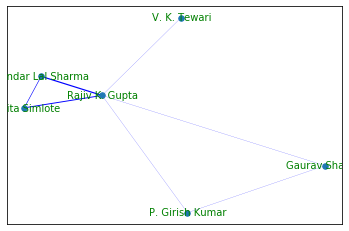

In [21]:
# Plotting one of the subgraphs
S = G.subgraph(subgraphs[1])
print(pd.DataFrame(S.edges(data=True)))
pos=nx.spring_layout(S) 
nx.draw_networkx_nodes(S, pos, node_size=30)
nx.draw_networkx_labels(S, pos, font_size=10,font_color='g')

all_weights = []
for (n1, n2, attr) in S.edges(data=True):
    all_weights.append(attr['weight'])
unique_weights = list(set(all_weights))

for wt in range(1, int(max(unique_weights))+1):
    edges = [(n1,n2) for (n1, n2, attr) in S.edges(data=True) if attr['weight']==wt]
    width = wt*len(edges)*3.0/sum(all_weights)
    nx.draw_networkx_edges(S, pos, edgelist=edges, width=width, edge_color='b')

This shows that there is one main "subgraph"/"network" with many other tiny subgraphs with authors that have residence in one dominant country and other countries in the network tend to be countries nearby.

Possible analysis: check how many "species" outputs the smaller subgraphs have to test their influence. For example, the "Jian Yao" network only described 3 species in total (not including those individually described/collaboratively) whereas the "Friese" network described 19 species.

Quote from tutorial: "This only scratches the surface of what can be done with network metrics in Python. NetworkX offers dozens of functions and measures for you to use in various combinations, and you can use Python to extend these measures in almost unlimited ways. A programming language like Python or R will give you the flexibility to explore your network computationally in ways other interfaces cannot by allowing you to combine and compare the statistical results of your network with other attributes of your data (like the dates and occupations you added to the network at the beginning of this tutorial!)."

## Modularity

In [21]:
communities = community.best_partition(G)

In [22]:
nx.set_node_attributes(G, communities, 'modularity')

In [23]:
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]; len(class0)

48

In [24]:
# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

In [25]:
# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: Michael Scott Engel | Eigenvector Centrality: 0.4607013143210458
Name: Terry L. Griswold | Eigenvector Centrality: 0.32146051380748536
Name: Victor Hugo Gonzalez [Betancourt] | Eigenvector Centrality: 0.29420394689460644
Name: Ricardo Ayala Barajas | Eigenvector Centrality: 0.19620102130148936
Name: Ismael Alejandro Hinojosa-Díaz | Eigenvector Centrality: 0.1845644245423236


In [26]:
modularity = {} # Create a new, empty dictionary
for k,v in communities.items(): # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k] # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k) # Append a name to the list for a modularity class the code has already seen

for k,v in modularity.items(): # Loop through the new dictionary
    if len(v) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(k)+':', v) # Print out the classes and their members

Class 0: ['Abdulaziz S. Alqarni', 'Allan Henry Smith-Pardo', 'Alvin Fleetwood Shinn', 'Andreas Müller', 'André Nemésio', 'Anne E. Dollin', 'Barrett Anthony Klein', 'Benjamin Bembé', 'Carlos Balboa', 'Carlos Hernan Vergara', 'Charlotte Skov', 'Claus Rasmussen', 'Daniel J. Bennett', 'David A. Tanner', 'Donald Burton Baker', 'Favízia Freitas de Oliveira', 'Frank D. Parker', 'George E. [Ned] Bohart', 'H. Glenn Hall', 'Ismael Alejandro Hinojosa-Díaz', 'Jakub Straka', 'John L. [Jack] Neff', 'John Stoskopf Ascher', 'Juan M. Labougle', 'Leah LaPerle Larkin', 'Leif D. Deyrup', 'Leslie J. Dollin', 'Marcio Luiz de Oliveira', 'Mark Amidon Deyrup', 'Michael Christopher Orr', 'Michael S. Arduser', 'Michael Scott Engel', 'Mohammed A. Hannan', 'Molly Greer Rightmyer', 'Olivia Yáñez-Ordóñez', 'Paula A. Sepúlveda', 'Rafael R. Ferrari', 'Ricardo Ayala Barajas', 'Richard W. Rust', 'Rita I. Velez-Ruiz', 'Terry L. Griswold', 'Thiago Mahlmann', 'Thomas Eltz', 'Thomas J. Pohl', 'Victor Hugo Gonzalez [Betancou